170498071/170498071 [==============================] - 18s 0us/step
Epoch 1/20
782/782 [==============================] - 41s 44ms/step - loss: 1.8942 - accuracy: 0.3239 - val_loss: 1.5603 - val_accuracy: 0.4560
Epoch 2/20
782/782 [==============================] - 32s 41ms/step - loss: 1.6431 - accuracy: 0.4292 - val_loss: 1.4266 - val_accuracy: 0.5196
Epoch 3/20
782/782 [==============================] - 33s 42ms/step - loss: 1.5544 - accuracy: 0.4745 - val_loss: 1.3739 - val_accuracy: 0.5350
Epoch 4/20
782/782 [==============================] - 34s 43ms/step - loss: 1.4995 - accuracy: 0.4987 - val_loss: 1.3850 - val_accuracy: 0.5482
Epoch 5/20
782/782 [==============================] - 33s 42ms/step - loss: 1.4570 - accuracy: 0.5213 - val_loss: 1.3248 - val_accuracy: 0.5651
Epoch 6/20
782/782 [==============================] - 33s 42ms/step - loss: 1.4166 - accuracy: 0.5396 - val_loss: 1.2073 - val_accuracy: 0.6118
Epoch 7/20
782/782 [==============================] - 32s 41ms/step 

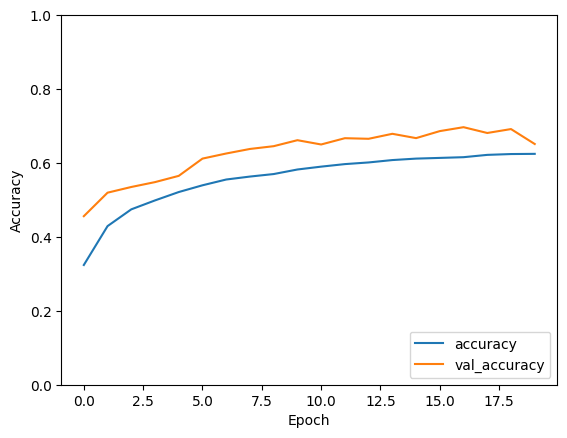

313/313 - 1s - loss: 1.1736 - accuracy: 0.6513 - 730ms/epoch - 2ms/step
Test accuracy: 0.6513000130653381
313/313 [==============================] - 1s 3ms/step


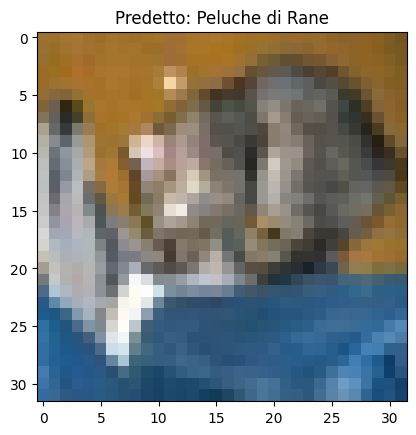

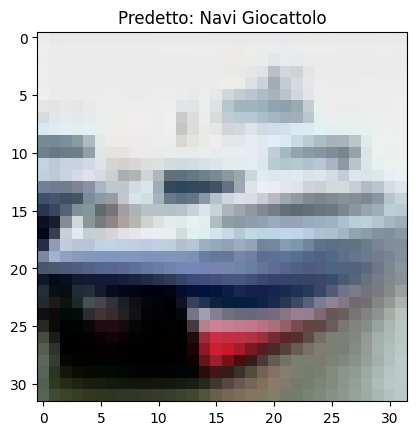

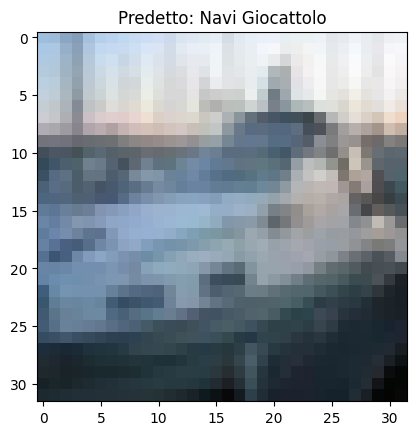

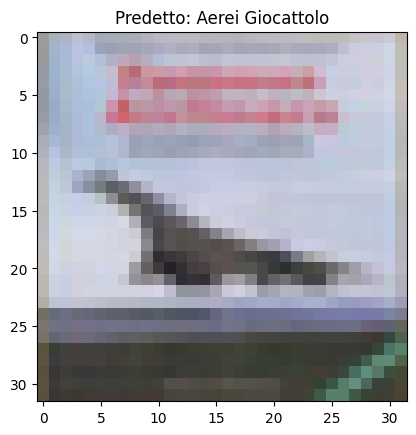

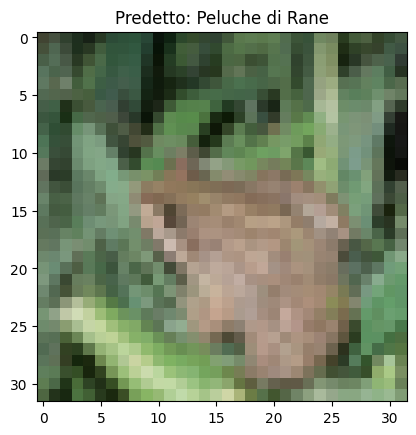

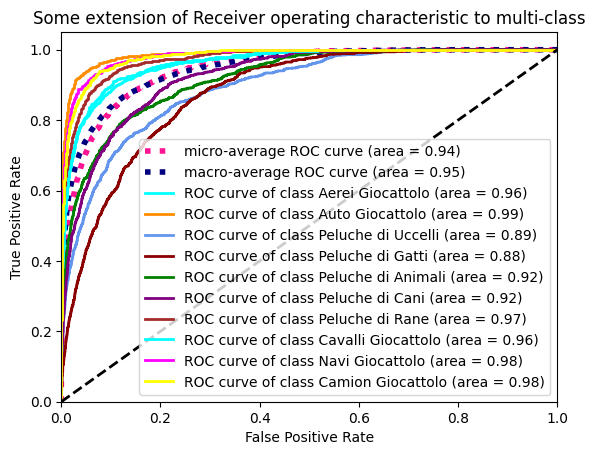

In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from itertools import cycle
from tensorflow.keras import regularizers
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 1. Categorie di Giocattoli
cifar10_labels = {
    0: "Aerei Giocattolo",
    1: "Auto Giocattolo",
    2: "Peluche di Uccelli",
    3: "Peluche di Gatti",
    4: "Peluche di Animali",
    5: "Peluche di Cani",
    6: "Peluche di Rane",
    7: "Cavalli Giocattolo",
    8: "Navi Giocattolo",
    9: "Camion Giocattolo"
}

# 2. Importare le librerie necessarie
import numpy as np
from tensorflow.keras.utils import to_categorical

# 3. Caricare e preparare il dataset CIFAR-10
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Normalizzare i valori dei pixel tra 0 e 1
train_images, test_images = train_images / 255.0, test_images / 255.0

# Convertire le etichette in categorie
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

# 4. Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
datagen.fit(train_images)

# 5. Costruire la CNN con Dropout e parametro di regolarizzazione
l2_reg = 0.0005

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3),
                        kernel_regularizer=regularizers.l2(l2_reg)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))  # Aggiungi Dropout

model.add(layers.Conv2D(64, (3, 3), activation='relu',
                        kernel_regularizer=regularizers.l2(l2_reg)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))  # Aggiungi Dropout

model.add(layers.Conv2D(64, (3, 3), activation='relu',
                        kernel_regularizer=regularizers.l2(l2_reg)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu',
                       kernel_regularizer=regularizers.l2(l2_reg)))
model.add(layers.Dropout(0.4))  # Aggiungi Dropout

model.add(layers.Dense(10, activation='softmax',
                       kernel_regularizer=regularizers.l2(l2_reg)))

# 6. Compilare la CNN
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 7. Addestrare la CNN con data augmentation
history = model.fit(datagen.flow(train_images, train_labels, batch_size=64),
                    epochs=20,
                    validation_data=(test_images, test_labels))

# 8. Valutare la CNN
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print(f"Test accuracy: {test_acc}")

# 9. Mappare le etichette del dataset CIFAR-10 alle categorie di giocattoli
def get_toy_category(prediction):
    return cifar10_labels[np.argmax(prediction)]

# Esempio di utilizzo del modello per classificare immagini
predictions = model.predict(test_images)

# Stampare le prime 5 immagini con la loro categoria predetta
for i in range(5):
    plt.imshow(test_images[i])
    plt.title(f"Predetto: {get_toy_category(predictions[i])}")
    plt.show()

# 10. Calcolare la curva ROC e AUC per ogni classe
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(cifar10_labels)

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(test_labels[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Calcolare ROC e AUC medi (macro e micro)
# ROC e AUC "micro"
fpr["micro"], tpr["micro"], _ = roc_curve(test_labels.ravel(), predictions.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# ROC e AUC "macro"
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot delle curve ROC per ciascuna classe
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'darkred', 'green', 'purple', 'brown', 'cyan', 'magenta', 'yellow'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(cifar10_labels[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()